In [1]:
# Import statements
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from keras import layers, models, regularizers

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.layers import TimeDistributed

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import os
import winsound
from sklearn.preprocessing import LabelEncoder
import datetime as dt

os.chdir('../scripts')
from functions import impute_immediate_mean, split_data, SMAPE,sMAPE, r2, compute_metrics, to_supervised
os.chdir('../notebooks')


In [2]:
# Set up alarm for notification of model completion
duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

## Read in Data

In [3]:
df_lag =pd.read_csv('../data/clean/df_clean_lag.csv', index_col=0, parse_dates=True)
TSO_preds = df_lag.price_day_ahead.copy()
y_true_train = df_lag.loc[:'2019', 'price_actual'].copy()
y_true_val = df_lag.loc['2020', 'price_actual'].copy()

## Continuous

In [4]:
continuous = df_lag.select_dtypes(exclude='object').drop(columns=['price_actual', 'price_day_ahead']).columns

# Get rid of negatives
time = dt.datetime(2021,3,24,22)
df_lag.loc[time, 'dew_point_bilbao_lag'] = impute_immediate_mean(df_lag['dew_point_bilbao_lag'], time)

# Rescale data [-1,1]
scaler = MinMaxScaler(feature_range=(-1, 1))
df_lag[continuous] = scaler.fit_transform(df_lag[continuous])

## Categoricals

In [5]:
# Get catergorical 
categorical = df_lag.select_dtypes(include='object').columns

# Get wind direction cols
wind_dirs = df_lag.filter(regex='wind(?!_speeds|_forecast)').columns

# Instantiate encoder and transfrom wind_dir cols
wind_dir_coder = LabelEncoder()
wind_dir_coder.fit(df_lag['wind_madrid_lag'])
for col in wind_dirs:
    df_lag[col] = wind_dir_coder.transform(df_lag[col])
    
# Stack condition columns into single col
stacked_conditions = df_lag.filter(regex='condition').stack()

# Instantiate Label encoder, fit and transform on condition cols
condition_coder = LabelEncoder()
condition_coder.fit(stacked_conditions)
for col in df_lag.filter(regex='condition').columns:
    df_lag[col] = condition_coder.transform(df_lag[col])

# Rescale data [-1,1]
df_lag[categorical] = scaler.fit_transform(df_lag[categorical])

## Split Data

In [16]:
# Get price components to drop
price_drop = df_lag.filter(regex='price_(?!actual|day)').columns

# Split data
X_train, y_train, X_val, y_val = split_data(df_lag.drop(columns=price_drop), 2020, 'price_actual')

### Results DataFrame

In [19]:
TSO_metrics = [round(sMAPE(y_true_train, TSO_preds.loc[:'2019']),3),
               round(sMAPE(y_true_val, TSO_preds.loc['2020']),3), 
               round(r2(y_true_train, TSO_preds.loc[:'2019']),3),
               round(r2(y_true_val, TSO_preds.loc['2020']),3)]
results_actual = pd.DataFrame({'TSO':TSO_metrics}, 
                              index=['sMAPE_train', 'sMAPE_val', 'r2_train', 'r2_val'])

## Neural Network

In [716]:
def compile_fit(nn, train, validation,
                patience=10,
                metric=SMAPE,
                #metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE'),
                loss = tf.keras.metrics.mean_absolute_error,
                batch_size = None):
    
    # Create early stopping point
    metric.name='SMAPE'
    callback = keras.callbacks.EarlyStopping(
        patience=patience,
        monitor='val_'+metric.name,
        mode='min',
        restore_best_weights=True
    )
    # Compile the model
    nn.compile(
        loss=loss, 
        optimizer=keras.optimizers.Adam(),
        metrics=metric
    )
    
    # Fit the model
    history = nn.fit(
        x = train[0],
        y = train[1],
        batch_size=batch_size,
        epochs = 200,
        callbacks=[callback],
        validation_data=validation
    )
    return nn

In [21]:
input_shape = (X_train.shape[1],)

In [22]:
# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.Dense(59, activation='relu', input_shape=input_shape))
nn.add(layers.Dense(239, activation='relu'))
nn.add(layers.Dense(162, activation='relu'))
nn.add(layers.Dense(1, activation='relu'))


In [23]:
nn1 = compile_fit(nn, (X_train,y_train), (X_val, y_val), patience=10,
                  loss = tf.keras.metrics.mean_absolute_error)

Epoch 1/200
1369/1369 [==============================] - 2s 1ms/step - loss: 2.1026 - SMAPE: 4.3472 - val_loss: 1.6477 - val_SMAPE: 4.7383
Epoch 2/200
1369/1369 [==============================] - 2s 1ms/step - loss: 1.5031 - SMAPE: 2.8752 - val_loss: 2.0099 - val_SMAPE: 5.6838
Epoch 3/200
1369/1369 [==============================] - 2s 1ms/step - loss: 1.4405 - SMAPE: 2.7427 - val_loss: 1.7656 - val_SMAPE: 5.0484
Epoch 4/200
1369/1369 [==============================] - 2s 1ms/step - loss: 1.3750 - SMAPE: 2.6169 - val_loss: 1.3846 - val_SMAPE: 4.0602
Epoch 5/200
1369/1369 [==============================] - 2s 1ms/step - loss: 1.3396 - SMAPE: 2.5426 - val_loss: 2.1048 - val_SMAPE: 6.1020
Epoch 6/200
1369/1369 [==============================] - 2s 1ms/step - loss: 1.2878 - SMAPE: 2.4418 - val_loss: 1.5532 - val_SMAPE: 4.7048
Epoch 7/200
1369/1369 [==============================] - 2s 1ms/step - loss: 1.2821 - SMAPE: 2.4256 - val_loss: 1.6325 - val_SMAPE: 4.9195
Epoch 8/200
1369/1369 [====

In [24]:
results_actual['nn1'] = compute_metrics(nn1, (X_train,y_train), (X_val, y_val))
results_actual

,TSO,nn1
sMAPE_train,16.030,2.908806
sMAPE_val,16.922,4.066236
r2_train,0.954,0.984056
r2_val,0.971,0.977619


In [14]:
X_val.columns

Index(['temp_madrid_lag', 'dew_point_madrid_lag', 'humidities_madrid_lag',
       'wind_madrid_lag', 'wind_speeds_madrid_lag', 'pressures_madrid_lag',
       'condition_madrid_lag', 'temp_seville_lag', 'dew_point_seville_lag',
       'humidities_seville_lag', 'wind_seville_lag', 'wind_speeds_seville_lag',
       'pressures_seville_lag', 'condition_seville_lag', 'temp_barcelona_lag',
       'dew_point_barcelona_lag', 'humidities_barcelona_lag',
       'wind_barcelona_lag', 'wind_speeds_barcelona_lag',
       'pressures_barcelona_lag', 'condition_barcelona_lag', 'temp_bilbao_lag',
       'dew_point_bilbao_lag', 'humidities_bilbao_lag', 'wind_bilbao_lag',
       'wind_speeds_bilbao_lag', 'pressures_bilbao_lag',
       'condition_bilbao_lag', 'temp_valencia_lag', 'dew_point_valencia_lag',
       'humidities_valencia_lag', 'wind_valencia_lag',
       'wind_speeds_valencia_lag', 'pressures_valencia_lag',
       'condition_valencia_lag', 'transmission_ps_lag', 'transmission_sp_lag',
       't

### Neural Network - Multivariate (24 hour prediction)

Restructure data for 24 hour input and output

In [227]:
X_train, y_train, X_val, y_val = split_data(df_lag.drop(columns=price_drop), 2020, 'price_actual')
#X_train, y_train, X_val, y_val = create_windows((X_train,y_train), (X_val, y_val), 24, 24)

In [ ]:
def pad_df(df, input_window):
    
    # Find minimum number of rows to add to df that makes divisible by input_window
    whole = len(df)//input_window
    decimal = len(df)/input_window
    missing_frac = 1 + (whole-decimal)
    num_rows_to_add = int(round(missing_frac*input_window))
    
    # Append the df to the first subset of rows of df and return
    df = df.iloc[:num_rows_to_add].append(df).copy()
    return df

In [294]:
def create_windows(train, test, input_window, output_window, padding='repeat'):
    
    # If the training set is not divisible by the output_window
    if train[0].shape[0]%input_window != 0:
        X_train = pad_df(train[0], input_window)
        y_train = train[1]
    if test[0].shape[0]%input_window != 0:
        X_test = pad_df(test[0], input_window)
        y_test =  test[1]

    else:
        X_train, y_train = train[0], train[1]
        X_test, y_test = test[0], test[1]
    X_train_windows = np.array(np.split(X_train, len(X_train)/input_window))
    y_train_windows = np.array(np.split(y_train, len(y_train)/output_window))
    X_val_windows = np.array(np.split(X_test, len(X_test)/input_window))
    y_val_windows = np.array(np.split(y_test, len(y_test)/output_window))
    return X_train_windows, y_train_windows, X_val_windows, y_val_windows

In [344]:
X_train, y_train, X_val, y_val = split_data(df_lag.drop(columns=price_drop), 2020, 'price_actual')
input_window=24*7
output_window=24
train, test = (X_train, y_train), (X_val, y_val)
stride = 24


def pad_df(df, input_window, output_window):
    # Find number of rows needed for first sample
    nrows = input_window-output_window
    # Append the df to the first subset of rows of df and return
    df = df.iloc[:nrows].append(df).copy()
    return df


def create_samples(train, test, input_window, output_window, padding='repeat'):
    if input_window >24: 
        X_train = pad_df(train[0], input_window, output_window)
        X_test = pad_df(test[0], input_window, output_window)
        y_train, y_test = train[1], test[1]

    else:
        X_train, y_train = train[0], train[1]
        X_test, y_test = test[0], test[1]

    i = 0
    X_train_resampled = pd.DataFrame()
    while i < len(X_train):
        X_train_resampled = pd.concat([X_train_resampled, X_train.iloc[i:i+input_window].copy()])
        i += stride
    i = 0
    X_test_resampled = pd.DataFrame()
    while i < len(X_test):
        X_test_resampled = pd.concat([X_test_resampled, X_val.iloc[i:i+input_window].copy()])
        i += stride

    # Split the data by the input and output windows
    X_train_windows = np.array(np.split(X_train_resampled, input_window))
    y_train_windows = np.array(np.split(y_train, len(y_train)/output_window))
    X_val_windows = np.array(np.split(X_test_resampled, input_window))
    y_val_windows = np.array(np.split(y_test, len(y_test)/output_window))
    return X_train_windows, y_train_windows, X_val_windows, y_val_windows

In [349]:
X_train, y_train, X_val, y_val = split_data(df_lag.drop(columns=price_drop), 2020, 'price_actual')

X_train, y_train, X_val, y_val = create_samples((X_train, y_train), (X_val, y_val), 24*7, 24)

In [350]:
X_train.shape

(168, 1828, 60)

In [351]:
y_train.shape

(1825, 24)

In [339]:
X_train_windows = np.array(np.split(X_train_resampled, input_window))

In [341]:
X_train_windows.shape

(168, 1828, 60)

In [334]:
len(X_train_resampled)/input_window

1828.0

In [330]:
X_train_resampled.shape

(307104, 60)

In [331]:
X_test_resampled.shape

(60984, 60)

In [327]:
X_train_resampled.shape

(307104, 60)

In [332]:
X_test_resampled

,temp_madrid_lag,dew_point_madrid_lag,humidities_madrid_lag,wind_madrid_lag,wind_speeds_madrid_lag,pressures_madrid_lag,condition_madrid_lag,temp_seville_lag,dew_point_seville_lag,humidities_seville_lag,...,solar_lag,waste_lag,onshore_lag,load_forecast,load_actual,solar_forecast,wind_forecast,generation_forecast,consumption_forecast,price_day_ahead
2020-01-01 00:00:00,-0.50,-0.184211,0.851064,-0.444444,-0.956522,0.970097,-0.864407,-0.099099,0.232877,0.64,...,-0.993716,0.484594,-0.821197,-0.395978,-0.492593,-0.997127,-0.867984,-0.546393,-1.000000,41.88
2020-01-01 01:00:00,-0.50,-0.184211,0.851064,-1.000000,-1.000000,0.968707,-0.864407,-0.135135,0.232877,0.74,...,-0.993716,0.462185,-0.824212,-0.451013,-0.556217,-0.997666,-0.861960,-0.589977,-0.976371,38.60
2020-01-01 02:00:00,-0.54,-0.184211,1.000000,-0.222222,-0.913043,0.968707,-0.864407,-0.135135,0.232877,0.74,...,-0.993716,0.439776,-0.831248,-0.546265,-0.657175,-0.998025,-0.856463,-0.602506,-0.853321,36.55
2020-01-01 03:00:00,-0.54,-0.184211,1.000000,-0.222222,-0.869565,0.968707,-0.864407,-0.135135,0.232877,0.74,...,-0.995461,0.450980,-0.818986,-0.639174,-0.751142,-0.998384,-0.853715,-0.580334,-0.599198,32.32
2020-01-01 04:00:00,-0.54,-0.236842,0.851064,-0.222222,-0.782609,0.968707,-0.864407,-0.171171,0.232877,0.86,...,-0.996509,0.450980,-0.815770,-0.694512,-0.810556,-0.998025,-0.852553,-0.557631,-0.244316,30.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,-0.32,-0.315789,0.000000,0.666667,-0.608696,0.941586,-0.864407,-0.189189,0.068493,0.62,...,-0.993890,0.344538,0.013920,0.230269,0.205687,-0.994614,-0.170489,0.212301,-1.000000,60.54
2020-12-31 20:00:00,-0.36,-0.289474,0.170213,-0.555556,-0.869565,0.941586,-0.864407,-0.225225,0.013699,0.62,...,-0.994414,0.378151,0.019448,0.196553,0.163033,-0.997127,-0.190995,0.139787,-1.000000,56.75
2020-12-31 21:00:00,-0.46,-0.289474,0.468085,-1.000000,-1.000000,0.941586,-0.864407,-0.261261,0.013699,0.74,...,-0.994588,0.355742,0.025278,0.068264,0.074387,-0.998205,-0.181799,-0.004480,-1.000000,52.44
2020-12-31 22:00:00,-0.50,-0.289474,0.595745,0.555556,-0.913043,0.941586,-0.864407,-0.297297,-0.013699,0.74,...,-0.994588,0.350140,0.014624,-0.143559,-0.136423,-0.997666,-0.189092,-0.149582,-1.000000,51.86


In [313]:
i = 0
stride = 24
X_train_resampled = pd.DataFrame()
X_test_resampled = pd.DataFrame()
while i < len(X_train):
    X_train_resampled = pd.concat([X_train_resampled, X_train.iloc[i:i+input_window].copy()])
    X_test_resampled = pd.concat([X_test_resampled, X_val.iloc[i:i+input_window].copy()])
    i += stride

In [314]:
X_train_resampled.

(307104, 60)

In [282]:
i=0
stride=24
X_train_resampled = pd.DataFrame()
X_train_resampled = pd.concat([X_train_resampled, X_train.iloc[i:i+stride].copy()])
X_train_resampled.shape

(24, 60)

In [283]:
i = 48
X_train_resampled = pd.concat([X_train_resampled, X_train.iloc[i:i+stride].copy()])
X_train_resampled.shape

(48, 60)

In [244]:
test = pd.DataFrame().append(X_train.iloc[0:24].copy())
test

,temp_madrid_lag,dew_point_madrid_lag,humidities_madrid_lag,wind_madrid_lag,wind_speeds_madrid_lag,pressures_madrid_lag,condition_madrid_lag,temp_seville_lag,dew_point_seville_lag,humidities_seville_lag,...,solar_lag,waste_lag,onshore_lag,load_forecast,load_actual,solar_forecast,wind_forecast,generation_forecast,consumption_forecast,price_day_ahead
2015-01-02 00:00:00,-0.58,-0.368421,0.574468,0.000000,-0.913043,0.974965,-0.864407,-0.333333,-0.123288,0.62,...,-0.991446,0.098039,-0.358963,-0.347672,-0.386552,-0.997666,-0.655745,-0.464617,-1.000000,47.34
2015-01-02 01:00:00,-0.58,-0.368421,0.574468,0.444444,-0.869565,0.977051,-0.864407,-0.333333,-0.123288,0.62,...,-0.991272,0.092437,-0.408010,-0.519050,-0.578538,-0.998205,-0.687982,-0.566894,-0.898350,40.40
2015-01-02 02:00:00,-0.64,-0.368421,0.851064,0.222222,-0.913043,0.977051,-0.864407,-0.339339,-0.123288,0.66,...,-0.991272,0.098039,-0.451128,-0.628288,-0.688629,-0.998384,-0.719374,-0.624222,-0.740080,36.00
2015-01-02 03:00:00,-0.64,-0.315789,1.000000,0.555556,-0.956522,0.977051,-0.864407,-0.345345,-0.123288,0.70,...,-0.991272,0.070028,-0.473541,-0.682567,-0.749394,-0.998025,-0.718317,-0.643508,-0.505127,37.00
2015-01-02 04:00:00,-0.68,-0.368421,1.000000,-1.000000,-1.000000,0.977051,-0.864407,-0.351351,-0.123288,0.74,...,-0.992668,0.058824,-0.503995,-0.707590,-0.767664,-0.998564,-0.734489,-0.647304,-0.497994,35.99
2015-01-02 05:00:00,-0.68,-0.421053,0.851064,-0.555556,-0.869565,0.979138,-0.864407,-0.333333,-0.178082,0.50,...,-0.994065,0.053221,-0.535856,-0.660493,-0.718972,-0.998564,-0.700772,-0.627411,-0.522069,37.98
2015-01-02 06:00:00,-0.72,-0.473684,0.851064,-0.555556,-0.913043,0.979138,-0.864407,-0.333333,-0.178082,0.50,...,-0.994065,0.042017,-0.558068,-0.524493,-0.556932,-0.998205,-0.690413,-0.552012,-0.641551,43.61
2015-01-02 07:00:00,-0.68,-0.421053,0.851064,-0.222222,-0.869565,0.979138,-0.864407,-0.351351,-0.178082,0.62,...,-0.993890,0.058824,-0.598774,-0.315921,-0.150641,-0.996768,-0.693056,-0.407517,-1.000000,56.10
2015-01-02 08:00:00,-0.72,-0.421053,1.000000,-1.000000,-1.000000,0.980529,-0.864407,-0.351351,-0.232877,0.50,...,-0.990573,0.109244,-0.635258,-0.088373,0.052504,-0.988688,-0.690519,-0.229613,-1.000000,57.69
2015-01-02 09:00:00,-0.76,-0.473684,1.000000,-0.555556,-0.869565,0.982615,-0.864407,-0.387387,-0.232877,0.62,...,-0.870298,0.109244,-0.691140,0.155806,0.154073,-0.875931,-0.717789,-0.003341,-1.000000,60.01


In [214]:
input_shape =  (X_train.shape[1], X_train.shape[2])

In [215]:
# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.Dense(59, activation='relu', input_shape=input_shape))
nn.add(layers.Dense(239, activation='relu'))
nn.add(layers.Dense(162, activation='relu'))
nn.add(TimeDistributed(layers.Dense(1)))

In [32]:
nn2 = compile_fit(nn, (X_train, y_train), (X_val, y_val))

Epoch 1/200
58/58 [==============================] - 1s 9ms/step - loss: 12.5959 - SMAPE: 31.7973 - val_loss: 2.5820 - val_SMAPE: 7.4359
Epoch 2/200
58/58 [==============================] - 0s 5ms/step - loss: 2.0735 - SMAPE: 4.0576 - val_loss: 1.8394 - val_SMAPE: 5.3152
Epoch 3/200
58/58 [==============================] - 0s 5ms/step - loss: 1.8062 - SMAPE: 3.5551 - val_loss: 1.6810 - val_SMAPE: 4.9280
Epoch 4/200
58/58 [==============================] - 0s 5ms/step - loss: 1.8048 - SMAPE: 3.4808 - val_loss: 1.7235 - val_SMAPE: 5.0120
Epoch 5/200
58/58 [==============================] - 0s 5ms/step - loss: 1.6775 - SMAPE: 3.2389 - val_loss: 2.2996 - val_SMAPE: 6.5282
Epoch 6/200
58/58 [==============================] - 0s 5ms/step - loss: 1.6385 - SMAPE: 3.1830 - val_loss: 1.5770 - val_SMAPE: 4.5829
Epoch 7/200
58/58 [==============================] - 0s 5ms/step - loss: 1.6894 - SMAPE: 3.2160 - val_loss: 2.0257 - val_SMAPE: 5.7407
Epoch 8/200
58/58 [==============================] - 

In [33]:
results_actual['nn2'] = compute_metrics(nn2, (X_train,y_train), (X_val, y_val))
results_actual

,TSO,nn1,nn2
sMAPE_train,16.030,2.908806,4.032132
sMAPE_val,16.922,4.066236,3.924490
r2_train,0.954,0.984056,0.979786
r2_val,0.971,0.977619,0.980031


SLIDING WINDOW GENERATOR

In [576]:
def window_gen(data, input_window, output_window, stride):
    '''
    Yields train and test samples of the given provided datasets, at specified input and out lengths, and specified strides
    
    PARAMETERS
    ----------
    train: tuple,
        Tuple of length 2, which provides the training features and training targets respectively
    test: tuple,
        Tuple of length 2, which provides the testing features and testing targets respectively
    input_window: int,
        Length of the sequence of input data
    output_window: int,
        Length of the sequence of output data
    stride, int
        Number of steps to move between first sample and second sample
    '''
    # Define X_train, y_train, X_test, y_test
    X, y = data[0], data[1]
    
    # Compute number of samples 
    n = len(X)/stride
    
    #
    if input_window > 24:
        n_add = input_window - 24
        X = X.iloc[:n_add].append(X)
    
    i=0
    for i in range(0, len(X)-n_add, stride):
        yield X.iloc[i:i+input_window].to_numpy(), y.iloc[i:i+output_window].to_numpy()
    #while i < len(X_train):
        #X_sample = X.iloc[i:i+input_window]
        #y_sample = y.iloc[i:i+output_window]
        #i += stride
        #yield X_sample, y_sample

In [629]:
X_train, y_train, X_val, y_val = split_data(df_lag.drop(columns=price_drop), 2020, 'price_actual')
train = window_gen((X_train, y_train), input_window=24*7, output_window=24, stride=24)
val = window_gen((X_val, y_val), input_window=24*7, output_window=24, stride=24)

In [649]:
def resample(data, input_window, output_window, stride):
    win = window_gen((data[0], data[1]), input_window=input_window, output_window=output_window, stride=stride)
    
    n = int(len(X_train)/stride)
    X_data = np.array([])
    y_data = np.array([])
    
    for i in range(n):
        X_sample, y_sample = next(win)
        X_data = np.append(X_data, X_sample)
        y_data = np.append(y_data, y_sample)
        
    # Reshape
    X_data = X_data.reshape(n,input_window,len(data[0].columns))
    y_data = y_data.reshape(n, output_window)
    
    return X_data, y_data

In [655]:
X_train, y_train, X_val, y_val = split_data(df_lag.drop(columns=price_drop), 2020, 'price_actual')
X_train, y_train = resample((X_train, y_train), 24*7, 24, 24)
X_val, y_val = resample((X_val,y_val), 24*7, 24, 24)

In [656]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(1825, 168, 60)
(1825, 24)
(76, 168, 60)
(76, 24)


In [630]:
input_window=24*7
output_window=24
n = int(len(X_train)/stride)
X_data = np.array([])
y_data = np.array([])
for i in range(n):
    X_sample, y_sample = next(win)
    X_data = np.append(X_data, X_sample)
    y_data = np.append(y_data, y_sample)
X_data = X_data.reshape(n,input_window,len(X_train.columns))
y_data = y_data.reshape(n, output_window)

In [633]:
print(X_data.shape)
print(y_data.shape)

(1825, 168, 60)
(1825, 24)


In [631]:
X_data

array([[[-5.80000000e-01, -3.68421053e-01,  5.74468085e-01, ...,
         -4.64616553e-01, -1.00000000e+00,  4.73400000e+01],
        [-5.80000000e-01, -3.68421053e-01,  5.74468085e-01, ...,
         -5.66894457e-01, -8.98350424e-01,  4.04000000e+01],
        [-6.40000000e-01, -3.68421053e-01,  8.51063830e-01, ...,
         -6.24221716e-01, -7.40080250e-01,  3.60000000e+01],
        ...,
        [-5.00000000e-01, -3.68421053e-01,  3.61702128e-01, ...,
          3.59908884e-02, -1.00000000e+00,  6.17500000e+01],
        [-5.40000000e-01, -3.68421053e-01,  4.68085106e-01, ...,
         -7.21336371e-02, -1.00000000e+00,  5.99600000e+01],
        [-5.40000000e-01, -3.68421053e-01,  4.68085106e-01, ...,
         -2.33333333e-01, -1.00000000e+00,  5.86900000e+01]],

       [[-6.20000000e-01, -3.68421053e-01,  7.02127660e-01, ...,
         -3.88078967e-01, -9.41150245e-01,  5.21000000e+01],
        [-6.20000000e-01, -3.68421053e-01,  7.02127660e-01, ...,
         -4.72703113e-01, -6.55595185e

In [640]:
y_data[1824]

array([41.86, 39.15, 36.46, 35.92, 34.98, 37.03, 36.61, 41.8 , 45.29,
       47.44, 48.08, 45.47, 45.35, 43.57, 43.81, 45.33, 47.81, 52.21,
       56.29, 54.08, 49.67, 46.23, 43.97, 42.44])

In [641]:
y_train.iloc[-24:]

2019-12-31 00:00:00    41.86
2019-12-31 01:00:00    39.15
2019-12-31 02:00:00    36.46
2019-12-31 03:00:00    35.92
2019-12-31 04:00:00    34.98
2019-12-31 05:00:00    37.03
2019-12-31 06:00:00    36.61
2019-12-31 07:00:00    41.80
2019-12-31 08:00:00    45.29
2019-12-31 09:00:00    47.44
2019-12-31 10:00:00    48.08
2019-12-31 11:00:00    45.47
2019-12-31 12:00:00    45.35
2019-12-31 13:00:00    43.57
2019-12-31 14:00:00    43.81
2019-12-31 15:00:00    45.33
2019-12-31 16:00:00    47.81
2019-12-31 17:00:00    52.21
2019-12-31 18:00:00    56.29
2019-12-31 19:00:00    54.08
2019-12-31 20:00:00    49.67
2019-12-31 21:00:00    46.23
2019-12-31 22:00:00    43.97
2019-12-31 23:00:00    42.44
Name: price_actual, dtype: float64

In [480]:
n = len(X_train)/24
i = 0 
while i < (len(X_train)):
    X_train, y_train = next(win)
    i += 24

In [712]:
X_train.shape

(1825, 168, 60)

In [713]:
y_train[0]

array([64.02, 58.46, 54.7 , 54.91, 53.07, 54.23, 58.22, 67.55, 70.33,
       71.26, 75.86, 73.65, 74.19, 71.51, 71.04, 71.24, 70.64, 72.85,
       82.55, 83.33, 83.23, 79.06, 76.2 , 71.75])

In [714]:
input_shape = (X_train.shape[1], X_train.shape[2])
# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.LSTM(60, activation='tanh', input_shape=input_shape))
nn.add(layers.RepeatVector(y_train.shape[1]))
nn.add(layers.LSTM(24, activation='tanh', return_sequences=True))
nn.add(TimeDistributed(layers.Dense(1)))

In [717]:
nn3 = compile_fit(nn, (X_train, y_train), (X_val, y_val))

Epoch 1/200
58/58 [==============================] - 6s 78ms/step - loss: 36.3296 - SMAPE: 90.4345 - val_loss: 20.1643 - val_SMAPE: 58.4264
Epoch 2/200
58/58 [==============================] - 4s 73ms/step - loss: 34.9471 - SMAPE: 85.1381 - val_loss: 18.8335 - val_SMAPE: 52.9478
Epoch 3/200
58/58 [==============================] - 4s 71ms/step - loss: 33.5716 - SMAPE: 80.1440 - val_loss: 17.5436 - val_SMAPE: 47.9317
Epoch 4/200
58/58 [==============================] - 4s 71ms/step - loss: 32.1918 - SMAPE: 76.0328 - val_loss: 16.2494 - val_SMAPE: 43.0501
Epoch 5/200
58/58 [==============================] - 4s 70ms/step - loss: 30.8168 - SMAPE: 70.8552 - val_loss: 14.9455 - val_SMAPE: 38.5560
Epoch 6/200
58/58 [==============================] - 4s 72ms/step - loss: 29.4629 - SMAPE: 66.4764 - val_loss: 13.7743 - val_SMAPE: 34.5996
Epoch 7/200
58/58 [==============================] - 4s 72ms/step - loss: 28.1101 - SMAPE: 62.1691 - val_loss: 12.5838 - val_SMAPE: 30.9997
Epoch 8/200
58/58 [=

58/58 [==============================] - 4s 73ms/step - loss: 3.3489 - SMAPE: 6.0884 - val_loss: 2.7595 - val_SMAPE: 7.9028
Epoch 61/200
58/58 [==============================] - 4s 77ms/step - loss: 3.2531 - SMAPE: 5.9628 - val_loss: 2.7972 - val_SMAPE: 7.9425
Epoch 62/200
58/58 [==============================] - 5s 78ms/step - loss: 3.1685 - SMAPE: 5.7660 - val_loss: 2.8648 - val_SMAPE: 7.7766
Epoch 63/200
58/58 [==============================] - 5s 79ms/step - loss: 3.1326 - SMAPE: 5.6924 - val_loss: 2.6653 - val_SMAPE: 7.5211
Epoch 64/200
58/58 [==============================] - 5s 79ms/step - loss: 3.1023 - SMAPE: 6.0401 - val_loss: 2.7468 - val_SMAPE: 7.8495
Epoch 65/200
58/58 [==============================] - 5s 79ms/step - loss: 2.9881 - SMAPE: 5.4535 - val_loss: 2.6445 - val_SMAPE: 7.3407
Epoch 66/200
58/58 [==============================] - 5s 81ms/step - loss: 3.0316 - SMAPE: 5.5991 - val_loss: 3.0784 - val_SMAPE: 8.6580
Epoch 67/200
58/58 [==============================] - 

In [719]:
preds = nn3.predict(X_val)
preds.shape

(76, 24, 1)

In [723]:
results_actual['nn3'] = compute_metrics(nn3,(X_train,y_train), (X_val,y_val))
results_actual

,TSO,nn1,nn2,nn3
sMAPE_train,16.030,2.908806,4.032132,4.819614
sMAPE_val,16.922,4.066236,3.924490,6.263882
r2_train,0.954,0.984056,0.979786,0.937627
r2_val,0.971,0.977619,0.980031,0.908647


In [724]:
input_shape = (X_train.shape[1], X_train.shape[2])
# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.LSTM(83, activation='tanh', input_shape=input_shape, return_sequences=True))
nn.add(layers.RepeatVector(y_train.shape[1]))
nn.add(layers.Dense(24, activation='relu'))
nn.add(TimeDistributed(layers.Dense(1)))

ValueError: Input 0 of layer repeat_vector_16 is incompatible with the layer: expected ndim=2, found ndim=3. Full shape received: (None, 168, 83)

In [ ]:
nn4 = compile_fit(nn, (X_train, y_train), (X_val, y_val))

ENCODER/DECODER LSTM

**ENCODER**:<br>
One or more LSTM layers can be used to implement the encoder model. The output is a fixed-size vector that represents the internal represntation of the input sequence. The number of memory cells in this layer defines the length of this fixed-size vector.
* Produces a two dimensional matrix of outputs, where the length is defined by the number of memory cells in the layer.

**DECODER**:
Must transform the learned interal representation of the input sequence into the correct output sequence. The output should be a TimeDistributed layer.
* Expects a 3D input of [samples, time steps, features] in order to produce a decoded sequence of some different length define by the problem

**Repeat Vector**:
* Repeats the provided 2D input multiple times to create a 3D output
* Use to transition from ENCODER - DECORDER


In [699]:
nn.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 24)                8160      
_________________________________________________________________
repeat_vector_11 (RepeatVect (None, 24, 24)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 24, 1)             25        
Total params: 12,889
Trainable params: 12,889
Non-trainable params: 0
_________________________________________________________________


In [671]:
y_val.shape

(76, 24)

for index in X_train4.index:


### DNN- LSTM

In [221]:
# Drop the price_drop cols
data = df_lag.drop(columns=price_drop)

# Split the data into train and validation
X_train, y_train, X_val, y_val = split_data(data, 2020, 'price_actual')

# Subset dnn cols
X_train_dnn = X_train.filter(regex='lag')
X_val_dnn = X_val.filter(regex='lag')

# Subset lstm cols
X_train_lstm = X_train.drop(columns=X_train_dnn.columns)
X_val_lstm = X_val.drop(columns=X_val_dnn.columns)

In [217]:
X_train_dnn, y_train, X_val_dnn, y_val = create_windows((X_train_dnn, y_train), (X_val_dnn, y_val), 24*7, 24)

In [218]:
X_train_dnn.shape

(1825, 24, 53)

In [220]:
y_train.shape

(1825, 24)

In [66]:
# Input_shape
input_shape = (X_train_dnn.shape[1], X_train_dnn.shape[2])

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.Dense(59, activation='relu', input_shape=input_shape))
nn.add(layers.Dense(239, activation='relu'))
nn.add(layers.Dense(162, activation='relu'))
nn.add(TimeDistributed(layers.Dense(1)))

In [70]:
dnn = compile_fit(nn, (X_train_dnn,y_train), (X_val_dnn, y_val), patience=10,
                  loss = tf.keras.metrics.mean_absolute_error)

Epoch 1/200
58/58 [==============================] - 1s 7ms/step - loss: 7.1709 - SMAPE: 13.7999 - val_loss: 15.7936 - val_SMAPE: 36.2453
Epoch 2/200
58/58 [==============================] - 0s 5ms/step - loss: 7.2504 - SMAPE: 13.7528 - val_loss: 13.1679 - val_SMAPE: 31.7116
Epoch 3/200
58/58 [==============================] - 0s 6ms/step - loss: 7.1908 - SMAPE: 13.6106 - val_loss: 14.4294 - val_SMAPE: 33.9231
Epoch 4/200
58/58 [==============================] - 0s 5ms/step - loss: 7.1933 - SMAPE: 13.8220 - val_loss: 12.6163 - val_SMAPE: 30.7177
Epoch 5/200
58/58 [==============================] - 0s 5ms/step - loss: 7.0261 - SMAPE: 13.6109 - val_loss: 14.1698 - val_SMAPE: 33.4584
Epoch 6/200
58/58 [==============================] - 0s 5ms/step - loss: 6.9741 - SMAPE: 13.1447 - val_loss: 14.0560 - val_SMAPE: 33.2725
Epoch 7/200
58/58 [==============================] - 0s 5ms/step - loss: 6.8338 - SMAPE: 13.0065 - val_loss: 12.5395 - val_SMAPE: 30.5537
Epoch 8/200
58/58 [===============

In [71]:
compute_metrics(dnn, (X_train_dnn, y_train), (X_val_dnn, y_val))

[13.258809300502557,
 29.424358739029838,
 0.5939931779008499,
 0.14228398023713856]

In [49]:
X_train_lstm.columns

Index(['load_forecast', 'load_actual', 'solar_forecast', 'wind_forecast',
       'generation_forecast', 'consumption_forecast', 'price_actual',
       'price_day_ahead'],
      dtype='object')

In [ ]:
preds = nn2.predict(X_train)

In [31]:
len(preds.shape)
train_shape = y_train.shape[0] * y_train.shape[1]
preds = preds.reshape(train_shape)
preds.shape

(43800,)

In [43]:
X_train_test = create_windows(train, 24)
X_val_test = create_windows(X_val, 24)
X_
print(X_train_test.shape)
print(X_val_test.shape)

(1825, 24, 59)
(366, 24, 59)


(1825, 24, 59)

In [31]:
# Convert sliced arrays into input/output sequences
X_train, y_train = to_supervised(train, n_input=window_len, n_out=window_len, stride=24)
X_val, y_val = to_supervised(val, n_input=window_len, n_out=window_len, stride=24)

input_shape =  (X_train.shape[1], X_train.shape[2])

(1824, 24, 59) (1824, 24)
(365, 24, 59) (365, 24)
(24, 59)


In [29]:
y_val

array([[40.83, 38.07, 37.14, ..., 35.21, 35.6 , 39.28],
       [36.76, 35.14, 33.78, ..., 33.11, 33.61, 35.23],
       [41.18, 35.74, 34.93, ..., 33.81, 33.73, 33.75],
       ...,
       [37.1 , 29.31, 24.83, ..., 24.69, 26.94, 33.29],
       [47.76, 44.29, 40.69, ..., 37.92, 40.4 , 47.6 ],
       [46.62, 42.43, 39.47, ..., 35.8 , 38.39, 41.38]])

In [16]:
train['price_actual'] = df_lag.loc[:'2019', 'price_actual']
val['price_actual'] = df_lag.loc['2020', 'price_actual']

print(train.shape)
print(val.shape)
print()

train = np.array(np.split(train, len(train)/24))
val = np.array(np.split(val, len(val)/24))
print(train.shape)
print(val.shape)


#X_train, y_train = to_supervised(train, n_input=24, n_out=24, stride=24)
#X_val, y_val = to_supervised(val, n_input=24, n_out=24, stride=24)
#input_shape=(X_train.shape[1], X_train.shape[2])

(43800, 74)
(8784, 74)

(43800, 75)
(8784, 75)

(1825, 24, 75)
(366, 24, 75)


In [44]:
# Instantiate model and build layers
nn_final = models.Sequential()
nn_final.add(layers.Dense(62, activation='relu', input_shape=(shape,)))
nn_final.add(layers.Dense(239, activation='relu'))
nn_final.add(layers.Dense(162, activation='relu'))
nn_final.add(layers.Dense(1, activation='relu'))


In [45]:
X_train, y_train, X_val, y_val = split_data(df, 2021)

bl_final = compile_fit(nn_final, X_train, y_train, (X_val, y_val),
                patience=10,
                loss = tf.keras.metrics.mean_absolute_error)
preds = bl_final.predict(X_val).flatten()
r2 = (np.corrcoef(y_val, preds)**2)[0][1]
print('r2:', r2)
print('mape:', mean_absolute_percentage_error(y_val, preds)*100)
print('smape:', SMAPE(y_val, preds))
loss, sMAPE_val = bl_final.evaluate(X_val, y_val, verbose=0)
print('smape:', sMAPE_val)

Epoch 1/200
1644/1644 [==============================] - 3s 1ms/step - loss: 1.9733 - sMAPE: 4.2737 - val_loss: 3.5257 - val_sMAPE: 3.9302
Epoch 2/200
1644/1644 [==============================] - 2s 1ms/step - loss: 1.5054 - sMAPE: 3.0898 - val_loss: 2.5294 - val_sMAPE: 3.1163
Epoch 3/200
1644/1644 [==============================] - 2s 1ms/step - loss: 1.4663 - sMAPE: 3.0000 - val_loss: 2.7105 - val_sMAPE: 3.2777
Epoch 4/200
1644/1644 [==============================] - 3s 2ms/step - loss: 1.4028 - sMAPE: 2.8682 - val_loss: 2.4926 - val_sMAPE: 3.0372
Epoch 5/200
1644/1644 [==============================] - 3s 2ms/step - loss: 1.3379 - sMAPE: 2.7306 - val_loss: 2.8074 - val_sMAPE: 3.3143
Epoch 6/200
1644/1644 [==============================] - 2s 1ms/step - loss: 1.3100 - sMAPE: 2.6720 - val_loss: 2.6923 - val_sMAPE: 3.1800
Epoch 7/200
1644/1644 [==============================] - 2s 1ms/step - loss: 1.2757 - sMAPE: 2.6006 - val_loss: 2.9182 - val_sMAPE: 3.5041
Epoch 8/200
1644/1644 [====

In [20]:
print('r2:', (np.corrcoef(y_val,TSO_preds.loc['2020'])**2)[0][1])
print('mape:', mean_absolute_percentage_error(y_val,TSO_preds.loc['2020'])*100)
print('smape:', SMAPE(y_val,TSO_preds.loc['2020']))

r2: 0.9714777867123521
mape: 14.959628546355278
smape: 16.918003049222687


In [18]:
X_train, y_train, X_test, y_test = split_data(df, 2021)
preds = bl.predict(X_test).flatten()
r2 = (np.corrcoef(y_test, preds)**2)[0][1]
print('r2:', r2)
print('mape:', mean_absolute_percentage_error(y_test, preds)*100)
print('smape:', SMAPE(y_test, preds))
resid_forecast = preds - y_test
resid_forecast

r2: 0.9974031129868238
mape: 3.210796692591586
smape: 3.334922035726982


2021-01-01 00:00:00    -0.131090
2021-01-01 01:00:00    -2.204759
2021-01-01 02:00:00    -1.673647
2021-01-01 03:00:00    -1.716557
2021-01-01 04:00:00    -2.175416
                         ...    
2021-12-30 19:00:00    -7.747296
2021-12-30 20:00:00    -5.384048
2021-12-30 21:00:00    -9.977943
2021-12-30 22:00:00   -13.360194
2021-12-30 23:00:00   -17.658956
Name: price_tomorrow, Length: 8736, dtype: float64

In [9]:
# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.Dense(239, activation='relu', input_shape=(X_train.shape[1],)))
nn.add(layers.Dense(162, activation='relu'))
nn.add(layers.Dense(1, activation='relu'))

# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
nn.compile(loss=tf.keras.metrics.mean_absolute_error, 
           optimizer=keras.optimizers.Adam(learning_rate=.0001),
           metrics=metric)

# Fit the model
history = nn.fit(x= X_train,
                 y=y_train,
                 batch_size=128,
                 epochs = 100,
                 callbacks=[callback],
                 validation_data=(X_val, y_val),
)

preds_train = nn.predict(X_train).flatten()
preds_val = nn.predict(X_val).flatten()

print('r2:',r2_score(y_train, preds_train))
print('r2:',(np.corrcoef(y_train, preds_train)**2)[0][1])

print('val r2:',r2_score(y_val, preds_val))
print('val r2:',(np.corrcoef(y_val, preds_val)**2)[0][1])

Epoch 1/100
334/334 [==============================] - 1s 2ms/step - loss: 42.3649 - MAPE: 83.3904 - val_loss: 24.8675 - val_MAPE: 111.7421
Epoch 2/100
334/334 [==============================] - 1s 2ms/step - loss: 24.3124 - MAPE: 68.8397 - val_loss: 23.3587 - val_MAPE: 100.0323
Epoch 3/100
334/334 [==============================] - 1s 2ms/step - loss: 23.2809 - MAPE: 62.0716 - val_loss: 22.6162 - val_MAPE: 96.2855
Epoch 4/100
334/334 [==============================] - 1s 2ms/step - loss: 22.5349 - MAPE: 60.1233 - val_loss: 21.8751 - val_MAPE: 94.0755
Epoch 5/100
334/334 [==============================] - 1s 2ms/step - loss: 21.7326 - MAPE: 58.6938 - val_loss: 21.1528 - val_MAPE: 95.9708
Epoch 6/100
334/334 [==============================] - 1s 2ms/step - loss: 20.7999 - MAPE: 56.7986 - val_loss: 20.1292 - val_MAPE: 94.3731
Epoch 7/100
334/334 [==============================] - 1s 2ms/step - loss: 19.6020 - MAPE: 55.6993 - val_loss: 18.8427 - val_MAPE: 95.4855
Epoch 8/100
334/334 [====

In [ ]:
X_train_, y_train, X_val, y_val = split_data(df, 2021)

In [ ]:
nn.predict(df)

In [42]:
# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.Dense(239, activation='relu', input_shape=(X_train.shape[1],),
                    kernel_regularizer=regularizers.L1(.0001)))
nn.add(layers.Dense(162, activation='relu', kernel_regularizer=regularizers.L1(.0001)))
nn.add(layers.Dense(1, activation='relu'))

# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
nn.compile(loss=tf.keras.metrics.mean_absolute_error, 
           optimizer=keras.optimizers.Adam(learning_rate=.0001),
           metrics=metric)

# Fit the model
history = nn.fit(x= X_train,
                 y=y_train,
                 batch_size=256,
                 epochs = 100,
                 callbacks=[callback],
                 validation_data=(X_val, y_val),
)

preds_train = nn.predict(X_train).flatten()
preds_val = nn.predict(X_val).flatten()

print('r2:',r2_score(y_train, preds_train))
print('r2:',(np.corrcoef(y_train, preds_train)**2)[0][1])

print('val r2:',r2_score(y_val, preds_val))
print('val r2:',(np.corrcoef(y_val, preds_val)**2)[0][1])

Epoch 1/100
167/167 [==============================] - 1s 4ms/step - loss: 40.7536 - MAPE: 82.2737 - val_loss: 29.4587 - val_MAPE: 112.3087
Epoch 2/100
167/167 [==============================] - 0s 3ms/step - loss: 27.4505 - MAPE: 78.2185 - val_loss: 25.6727 - val_MAPE: 95.6277
Epoch 3/100
167/167 [==============================] - 0s 3ms/step - loss: 24.9472 - MAPE: 65.1849 - val_loss: 23.9091 - val_MAPE: 81.0519
Epoch 4/100
167/167 [==============================] - 1s 3ms/step - loss: 23.1896 - MAPE: 55.6207 - val_loss: 22.2045 - val_MAPE: 68.1717
Epoch 5/100
167/167 [==============================] - 0s 3ms/step - loss: 21.1731 - MAPE: 47.3178 - val_loss: 20.1566 - val_MAPE: 54.0342
Epoch 6/100
167/167 [==============================] - 0s 3ms/step - loss: 18.9979 - MAPE: 40.0940 - val_loss: 18.0588 - val_MAPE: 41.6691
Epoch 7/100
167/167 [==============================] - 0s 3ms/step - loss: 16.8930 - MAPE: 35.7444 - val_loss: 16.0439 - val_MAPE: 28.6478
Epoch 8/100
167/167 [=====

## Neural Network - 24 Hour Prediction 
Two hidden layers
### Data Preparation

In [21]:
def to_supervised(train, n_input, n_out=7, stride=1):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :-1])
            y.append(data[in_end:out_end, -1])
        # move along one time step
        in_start += stride
    return np.array(X), np.array(y)

In [30]:
train = df.loc[:'2019'].drop(columns='price_tomorrow')
val = df.loc['2020'].drop(columns='price_tomorrow')

train['price_tomorrow'] = df.loc[:'2019', 'price_tomorrow']
val['price_tomorrow'] = df.loc['2020', 'price_tomorrow']

train = np.array(np.split(train, len(train)/24))
val = np.array(np.split(val, len(val)/24))
print(train.shape)
print(val.shape)


X_train, y_train = to_supervised(train, n_input=24, n_out=24, stride=24)
X_val, y_val = to_supervised(val, n_input=24, n_out=24, stride=24)
input_shape=(X_train.shape[1], X_train.shape[2])

(1826, 24, 62)
(366, 24, 62)


In [31]:
# Instantiate model and build layers
bm = models.Sequential()
bm.add(layers.Dense(62, activation='relu', input_shape=input_shape))
bm.add(layers.Dense(239, activation='relu'))
bm.add(layers.Dense(162, activation='relu'))
bm.add(TimeDistributed(layers.Dense(1)))

Notes:

* <u>monitor_metric & metric (MAPE)</u>:  chosen because sMAPE not available. Chance to hard code sMAPE and implement?
* <u>patience (10)</u>: chosen to prevent reaching local minimum
* <u>loss function (mean_absolute_error)</u>: chosen because as the electricity prices have large spikes, the Euclidean norm would put too much importance on the spiky prices
* 

In [32]:
# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
bm.compile(loss=tf.keras.metrics.mean_absolute_error, 
           optimizer=keras.optimizers.Adam(),
           metrics=metric)

# Fit the model
history = bm.fit(x= X_train,
                 y=y_train,
                 epochs = 100,
                 callbacks=[callback],
                 batch_size=32,
                 validation_data=(X_val, y_val),
)

preds_train = bm.predict(X_train).flatten()
preds_val = bm.predict(X_val).flatten()


print('train r2:',r2_score(y_train.flatten(), preds_train))
print('train r2:',(np.corrcoef(y_train.flatten(), preds_train)**2)[0][1])

print('val r2:',r2_score(y_val.flatten(), preds_val))
print('val r2:',(np.corrcoef(y_val.flatten(), preds_val)**2)[0][1])

Epoch 1/100
58/58 [==============================] - 1s 6ms/step - loss: 12.8354 - MAPE: 23.8156 - val_loss: 6.6339 - val_MAPE: 20.9957
Epoch 2/100
58/58 [==============================] - 0s 4ms/step - loss: 6.2299 - MAPE: 12.9851 - val_loss: 6.3519 - val_MAPE: 20.7919
Epoch 3/100
58/58 [==============================] - 0s 4ms/step - loss: 5.9734 - MAPE: 12.6865 - val_loss: 7.3727 - val_MAPE: 24.7458
Epoch 4/100
58/58 [==============================] - 0s 5ms/step - loss: 5.9424 - MAPE: 12.5946 - val_loss: 8.1275 - val_MAPE: 27.1244
Epoch 5/100
58/58 [==============================] - 0s 4ms/step - loss: 5.9886 - MAPE: 12.7219 - val_loss: 7.2862 - val_MAPE: 24.4366
Epoch 6/100
58/58 [==============================] - 0s 4ms/step - loss: 5.7854 - MAPE: 12.3688 - val_loss: 5.4870 - val_MAPE: 18.0086
Epoch 7/100
58/58 [==============================] - 0s 4ms/step - loss: 5.7725 - MAPE: 12.2448 - val_loss: 6.0984 - val_MAPE: 20.8754
Epoch 8/100
58/58 [==============================] - 0

In [38]:
# Instantiate model and build layers
bm = models.Sequential()
bm.add(layers.Dense(239, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l1(0.9)))
bm.add(layers.Dropout(.9))
bm.add(layers.Dense(162, activation='relu', kernel_regularizer=regularizers.l1(0.9)))
bm.add(layers.Dropout(.9))
bm.add(TimeDistributed(layers.Dense(1)))

In [39]:
# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
bm.compile(loss=tf.keras.metrics.mean_absolute_error, 
           optimizer=keras.optimizers.Adam(),
           metrics=metric)

# Fit the model
history = bm.fit(x= X_train,
                 y=y_train,
                 epochs = 200,
                 callbacks=[callback],
                 batch_size=512,
                 validation_data=(X_val, y_val),
)

preds_train = bm.predict(X_train).flatten()
preds_val = bm.predict(X_val).flatten()

print('train r2:',r2_score(y_train.flatten(), preds_train))
print('train r2:',(np.corrcoef(y_train.flatten(), preds_train)**2)[0][1])

print('val r2:',r2_score(y_val.flatten(), preds_val))
print('val r2:',(np.corrcoef(y_val.flatten(), preds_val)**2)[0][1])

Epoch 1/200
4/4 [==============================] - 1s 123ms/step - loss: 3070.5112 - MAPE: 101.8340 - val_loss: 2922.1626 - val_MAPE: 101.8104
Epoch 2/200
4/4 [==============================] - 0s 93ms/step - loss: 2883.5691 - MAPE: 101.3586 - val_loss: 2739.7991 - val_MAPE: 101.1662
Epoch 3/200
4/4 [==============================] - 0s 84ms/step - loss: 2703.2878 - MAPE: 100.7100 - val_loss: 2563.8469 - val_MAPE: 100.5940
Epoch 4/200
4/4 [==============================] - 0s 105ms/step - loss: 2529.2197 - MAPE: 100.2305 - val_loss: 2394.1724 - val_MAPE: 100.0971
Epoch 5/200
4/4 [==============================] - 0s 88ms/step - loss: 2361.3186 - MAPE: 99.6174 - val_loss: 2230.2959 - val_MAPE: 99.6700
Epoch 6/200
4/4 [==============================] - 0s 99ms/step - loss: 2199.3940 - MAPE: 99.2076 - val_loss: 2072.3784 - val_MAPE: 99.3002
Epoch 7/200
4/4 [==============================] - 0s 85ms/step - loss: 2043.2935 - MAPE: 98.9438 - val_loss: 1920.2661 - val_MAPE: 98.9757
Epoch 8/20

In [78]:
# Instantiate model and build layers
bm = models.Sequential()
bm.add(layers.Dense(239, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l1(0)))
bm.add(layers.Dropout(.9))
bm.add(layers.Dense(162, activation='relu', kernel_regularizer=regularizers.l1(0)))
bm.add(layers.Dropout(.9))
bm.add(TimeDistributed(layers.Dense(1)))

# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
bm.compile(loss=tf.keras.metrics.mean_absolute_error, 
           optimizer=keras.optimizers.Adam(),
           metrics=metric)

# Fit the model
history = bm.fit(x= X_train,
                 y=y_train,
                 epochs = 100,
                 callbacks=[callback],
                 batch_size=128,
                 validation_data=(X_val, y_val),
)

preds_train = bm.predict(X_train).flatten()
preds_val = bm.predict(X_val).flatten()

print('train r2:',r2_score(y_train.flatten(), preds_train))
print('train r2:',(np.corrcoef(y_train.flatten(), preds_train)**2)[0][1])

print('val r2:',r2_score(y_val.flatten(), preds_val))
print('val r2:',(np.corrcoef(y_val.flatten(), preds_val)**2)[0][1])

Epoch 1/100
15/15 [==============================] - 1s 36ms/step - loss: 45.4839 - MAPE: 91.9167 - val_loss: 14.1024 - val_MAPE: 66.8014
Epoch 2/100
15/15 [==============================] - 0s 29ms/step - loss: 33.7040 - MAPE: 79.5775 - val_loss: 11.1353 - val_MAPE: 52.1070
Epoch 3/100
15/15 [==============================] - 0s 27ms/step - loss: 29.3823 - MAPE: 66.4293 - val_loss: 10.0158 - val_MAPE: 47.2930
Epoch 4/100
15/15 [==============================] - 0s 27ms/step - loss: 27.3341 - MAPE: 62.4996 - val_loss: 9.8122 - val_MAPE: 45.6371
Epoch 5/100
15/15 [==============================] - 0s 28ms/step - loss: 25.9432 - MAPE: 55.5520 - val_loss: 9.7036 - val_MAPE: 45.2370
Epoch 6/100
15/15 [==============================] - 0s 28ms/step - loss: 25.4551 - MAPE: 56.4819 - val_loss: 9.4428 - val_MAPE: 42.3645
Epoch 7/100
15/15 [==============================] - 0s 28ms/step - loss: 24.9479 - MAPE: 53.2063 - val_loss: 9.4181 - val_MAPE: 42.3927
Epoch 8/100
15/15 [===================

In [81]:
# Instantiate model and build layers
bm = models.Sequential()
bm.add(layers.Dense(239, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l1(0.001)))
bm.add(layers.Dropout(.9))
bm.add(layers.Dense(162, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
bm.add(layers.Dropout(.9))
bm.add(TimeDistributed(layers.Dense(1)))

# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
bm.compile(loss=tf.keras.metrics.mean_absolute_error, 
           optimizer=keras.optimizers.Adam(),
           metrics=metric)

# Fit the model
history = bm.fit(x= X_train,
                 y=y_train,
                 epochs = 100,
                 callbacks=[callback],
                 batch_size=128,
                 validation_data=(X_val, y_val),
)

preds_train = bm.predict(X_train).flatten()
preds_val = bm.predict(X_val).flatten()

print('train r2:',r2_score(y_train.flatten(), preds_train))
print('train r2:',(np.corrcoef(y_train.flatten(), preds_train)**2)[0][1])

print('val r2:',r2_score(y_val.flatten(), preds_val))
print('val r2:',(np.corrcoef(y_val.flatten(), preds_val)**2)[0][1])

Epoch 1/100
15/15 [==============================] - 1s 39ms/step - loss: 46.8585 - MAPE: 90.4892 - val_loss: 17.5185 - val_MAPE: 67.1698
Epoch 2/100
15/15 [==============================] - 0s 31ms/step - loss: 36.7941 - MAPE: 79.6642 - val_loss: 13.9950 - val_MAPE: 47.4856
Epoch 3/100
15/15 [==============================] - 0s 29ms/step - loss: 32.5062 - MAPE: 66.7438 - val_loss: 13.3872 - val_MAPE: 48.3413
Epoch 4/100
15/15 [==============================] - 0s 29ms/step - loss: 30.4398 - MAPE: 60.3333 - val_loss: 12.8435 - val_MAPE: 44.3023
Epoch 5/100
15/15 [==============================] - 0s 29ms/step - loss: 28.9885 - MAPE: 53.8950 - val_loss: 12.7383 - val_MAPE: 45.2990
Epoch 6/100
15/15 [==============================] - 0s 29ms/step - loss: 28.0770 - MAPE: 54.0073 - val_loss: 12.3631 - val_MAPE: 42.5779
Epoch 7/100
15/15 [==============================] - 0s 31ms/step - loss: 27.3943 - MAPE: 52.5591 - val_loss: 12.2777 - val_MAPE: 43.1760
Epoch 8/100
15/15 [===============

### Limit Price Spikes
Limit price spikes to +- 3*STD

<AxesSubplot:>

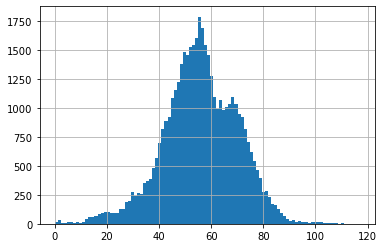

In [86]:
df.loc[:'2019', 'price_tomorrow'].hist(bins=100)

In [33]:
# Get train data, move price column to the end of set
train = df.loc[:'2019'].drop(columns='price_tomorrow')
train['price_tomorrow'] = df.loc[:'2019', 'price_tomorrow']

# Get price_tomorrow std, mean
price_std = df.loc[:'2019', 'price_tomorrow'].std()
price_mean = df.loc[:'2019', 'price_tomorrow'].mean()

# Copy price data and trim
train_trimmed = train.copy()
train_trimmed.loc[train_trimmed.price_tomorrow>(price_mean + price_std*3), 'price_tomorrow'] = price_mean + price_std*3

# Prep trimmed set for modeling
train_trimmed = np.array(np.split(train_trimmed, len(train_trimmed)/24))
X_train_trimmed, y_train_trimmed = to_supervised(train_trimmed, n_input=24, n_out=24, stride=24)
input_shape=(X_train_trimmed.shape[1], X_train_trimmed.shape[2])

In [37]:
# Instantiate model and build layers
bm_1 = models.Sequential()
bm_1.add(layers.Dense(62, activation='relu', input_shape=input_shape))
bm_1.add(layers.Dense(239, activation='relu'))
bm_1.add(layers.Dense(162, activation='relu'))
bm_1.add(TimeDistributed(layers.Dense(1)))

# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
bm_1.compile(loss=tf.keras.metrics.mean_absolute_error, 
           optimizer=keras.optimizers.Adam(),
           metrics=metric)

# Fit the model
history = bm_1.fit(x= X_train_trimmed,
                 y=y_train_trimmed,
                 epochs = 100,
                 callbacks=[callback],
                 batch_size=128,
                 validation_data=(X_val, y_val),
)

preds_train = bm_1.predict(X_train_trimmed).flatten()
preds_val = bm_1.predict(X_val).flatten()

print('train r2:',r2_score(y_train_trimmed.flatten(), preds_train))
print('train r2:',(np.corrcoef(y_train.flatten(), preds_train)**2)[0][1])

print('val r2:',r2_score(y_val.flatten(), preds_val))
print('val r2:',(np.corrcoef(y_val.flatten(), preds_val)**2)[0][1])

Epoch 1/100
15/15 [==============================] - 1s 19ms/step - loss: 27.5423 - MAPE: 48.7608 - val_loss: 11.3260 - val_MAPE: 32.1205
Epoch 2/100
15/15 [==============================] - 0s 11ms/step - loss: 9.4534 - MAPE: 18.0859 - val_loss: 5.8631 - val_MAPE: 17.3613
Epoch 3/100
15/15 [==============================] - 0s 10ms/step - loss: 6.9641 - MAPE: 13.8306 - val_loss: 5.6631 - val_MAPE: 16.9238
Epoch 4/100
15/15 [==============================] - 0s 11ms/step - loss: 6.3103 - MAPE: 12.8144 - val_loss: 6.1048 - val_MAPE: 19.4528
Epoch 5/100
15/15 [==============================] - 0s 11ms/step - loss: 6.0803 - MAPE: 12.8012 - val_loss: 6.6318 - val_MAPE: 22.0523
Epoch 6/100
15/15 [==============================] - 0s 10ms/step - loss: 5.9934 - MAPE: 12.6876 - val_loss: 6.1971 - val_MAPE: 20.4445
Epoch 7/100
15/15 [==============================] - 0s 11ms/step - loss: 5.9179 - MAPE: 12.5849 - val_loss: 6.8428 - val_MAPE: 22.7620
Epoch 8/100
15/15 [===========================

Trimming the training response variable did not improve model performance much.

## LSTM - DNN
### DNN

In [38]:
# Get columns representing future information 
DNN_cols = df.filter(regex='forecast').columns

train = df.loc[:'2019', DNN_cols].copy()
val = df.loc['2020', DNN_cols].copy()

train['price_tomorrow'] = df.loc[:'2019', 'price_tomorrow']
val['price_tomorrow'] = df.loc['2020', 'price_tomorrow']

train = np.array(np.split(train, len(train)/24))
val = np.array(np.split(val, len(val)/24))
print(train.shape)
print(val.shape)


X_train, y_train = to_supervised(train, n_input=24, n_out=24, stride=24)
X_val, y_val = to_supervised(val, n_input=24, n_out=24, stride=24)
input_shape=(X_train.shape[1], X_train.shape[2])
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(1826, 24, 7)
(366, 24, 7)
(1825, 24, 6) (1825, 24)
(365, 24, 6) (365, 24)


In [ ]:
# Instantiate model and build layers
bm_1 = models.Sequential()
bm_1.add(layers.Dense(62, activation='relu', input_shape=input_shape))
bm_1.add(layers.Dense(239, activation='relu'))
bm_1.add(layers.Dense(162, activation='relu'))
bm_1.add(TimeDistributed(layers.Dense(1)))

In [40]:
dnn = models.Sequential()
dnn.add(layers.Dense(62, activation='relu', input_shape=input_shape))
dnn.add(layers.Dense(239, activation='relu'))
dnn.add(layers.Dense(162, activation='relu'))
dnn.add(TimeDistributed(layers.Dense(1)))

# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
dnn.compile(loss=tf.keras.metrics.mean_absolute_error, 
            optimizer=keras.optimizers.Adam(),
            metrics=metric)

# Fit the model
history = dnn.fit(x= X_train,
                  y=y_train,
                  epochs = 100,
                  callbacks=[callback],
                  batch_size=128,
                  validation_data=(X_val, y_val),
)

preds_train = dnn.predict(X_train).flatten()
preds_val = dnn.predict(X_val).flatten()

print('train r2:',r2_score(y_train.flatten(), preds_train))
print('train r2:',(np.corrcoef(y_train.flatten(), preds_train)**2)[0][1])

print('val r2:',r2_score(y_val.flatten(), preds_val))
print('val r2:',(np.corrcoef(y_val.flatten(), preds_val)**2)[0][1])

Epoch 1/100
15/15 [==============================] - 1s 22ms/step - loss: 31.1012 - MAPE: 54.8837 - val_loss: 7.6221 - val_MAPE: 22.0542
Epoch 2/100
15/15 [==============================] - 0s 15ms/step - loss: 9.5633 - MAPE: 18.6024 - val_loss: 6.4179 - val_MAPE: 18.1986
Epoch 3/100
15/15 [==============================] - 0s 15ms/step - loss: 6.9690 - MAPE: 13.9584 - val_loss: 6.0370 - val_MAPE: 17.4881
Epoch 4/100
15/15 [==============================] - 0s 15ms/step - loss: 6.7030 - MAPE: 13.4970 - val_loss: 5.9364 - val_MAPE: 17.4142
Epoch 5/100
15/15 [==============================] - 0s 14ms/step - loss: 6.6260 - MAPE: 13.3519 - val_loss: 5.8679 - val_MAPE: 17.1270
Epoch 6/100
15/15 [==============================] - 0s 15ms/step - loss: 6.5688 - MAPE: 13.1972 - val_loss: 5.7908 - val_MAPE: 16.9660
Epoch 7/100
15/15 [==============================] - 0s 18ms/step - loss: 6.4767 - MAPE: 13.0076 - val_loss: 5.6648 - val_MAPE: 16.5560
Epoch 8/100
15/15 [============================

### LSTM

In [116]:
# Get columns representing past information 
LSTM_cols = list(set(df.columns) - set(DNN_cols))

train_LSTM = df.loc[:'2019', LSTM_cols].copy()
val_LSTM = df.loc['2020', LSTM_cols].copy()

train_LSTM['price_tomorrow'] = df.loc[:'2019', 'price_tomorrow']
val_LSTM['price_tomorrow'] = df.loc['2020', 'price_tomorrow']

train_LSTM = np.array(np.split(train_LSTM, len(train_LSTM)/24))
val_LSTM = np.array(np.split(val_LSTM, len(val_LSTM)/24))
print(train_LSTM.shape)
print(val_LSTM.shape)


X_train_LSTM, y_train_LSTM = to_supervised(train, n_input=24, n_out=24, stride=24)
X_val_LSTM, y_val_LSTM = to_supervised(val, n_input=24, n_out=24, stride=24)
input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])
print(X_train_LSTM.shape, y_train_LSTM.shape)
print(X_val_LSTM.shape, y_val_LSTM.shape)

(1825, 24, 57)
(366, 24, 57)
(1824, 24, 6) (1824, 24)
(365, 24, 6) (365, 24)


In [118]:
y_train_LSTM.shape[1]*7

168

In [107]:
from keras.layers import RepeatVector

In [165]:
lstm = keras.Sequential()
lstm.add(layers.LSTM(83, activation='tanh', input_shape=input_shape))
lstm.add(RepeatVector(y_train_LSTM.shape[1]))
lstm.add(layers.Dense(184, activation='relu', kernel_regularizer=regularizers.l1(0.1)))
lstm.add(TimeDistributed(layers.Dense(1)))

# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
dnn.compile(loss=tf.keras.metrics.mean_absolute_error, 
            optimizer=keras.optimizers.Adam(),
            metrics=metric)

# Fit the model
history = dnn.fit(x= X_train_LSTM,
                  y=y_train_LSTM,
                  epochs = 100,
                  callbacks=[callback],
                  batch_size=128,
                  validation_data=(X_val_LSTM, y_val_LSTM),
)

preds_train = dnn.predict(X_train_LSTM).flatten()
preds_val = dnn.predict(X_val_LSTM).flatten()

print('train r2:',r2_score(y_train_LSTM.flatten(), preds_train))
print('train r2:',(np.corrcoef(y_train_LSTM.flatten(), preds_train)**2)[0][1])

print('val r2:',r2_score(y_val_LSTM.flatten(), preds_val))
print('val r2:',(np.corrcoef(y_val_LSTM.flatten(), preds_val)**2)[0][1])

Epoch 1/100
15/15 [==============================] - 1s 38ms/step - loss: 26.6459 - MAPE: 48.2963 - val_loss: 14.2966 - val_MAPE: 51.7783
Epoch 2/100
15/15 [==============================] - 0s 28ms/step - loss: 25.3086 - MAPE: 45.2933 - val_loss: 13.4928 - val_MAPE: 53.2092
Epoch 3/100
15/15 [==============================] - 0s 28ms/step - loss: 24.1907 - MAPE: 46.2159 - val_loss: 13.4061 - val_MAPE: 55.4275
Epoch 4/100
15/15 [==============================] - 0s 29ms/step - loss: 23.3549 - MAPE: 46.3062 - val_loss: 13.2973 - val_MAPE: 57.4276
Epoch 5/100
15/15 [==============================] - 0s 28ms/step - loss: 22.4916 - MAPE: 46.2195 - val_loss: 13.4286 - val_MAPE: 59.3083
Epoch 6/100
15/15 [==============================] - 0s 28ms/step - loss: 21.9316 - MAPE: 45.3119 - val_loss: 13.7680 - val_MAPE: 61.9331
Epoch 7/100
15/15 [==============================] - 0s 29ms/step - loss: 21.4020 - MAPE: 44.5079 - val_loss: 13.7720 - val_MAPE: 63.9574
Epoch 8/100
15/15 [===============

In [125]:
np.corrcoef(df['price_forecast_tomorrow'].values, df.price_tomorrow)**2

array([[1.        , 0.48064142],
       [0.48064142, 1.        ]])

### Ensemble LSTM-DNN Model

## GRU - DNN

## CNN